Implementation of : [Multi-Label Missing Labels](https://ieeexplore.ieee.org/document/6977055) for the Yeast Dataset.

In [1]:
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm

Binarize labels

In [2]:
data_df = pd.read_csv('yeast.data', header=None, delimiter=r"\s+")
mlb = MultiLabelBinarizer()
print(data_df.columns.values)
data_df = data_df.join(pd.DataFrame(mlb.fit_transform(data_df.pop(9)),
                          columns=mlb.classes_,
                          index=data_df.index))

[0 1 2 3 4 5 6 7 8 9]


Convert labels to -1 and 1

In [3]:
y_modified_data_df = data_df.copy()
y_modified_data_df.iloc[:,-1 * len(mlb.classes_):] = y_modified_data_df.iloc[:, -1 * len(mlb.classes_):]\
    .replace(0, -1)
y_modified_data_df.head()

0     1     2     3     4    5    6     7     8  1  ...  M  N  O  \
0  ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22 -1  ...  1 -1 -1   
1  ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22 -1  ...  1 -1 -1   
2  ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22 -1  ...  1 -1 -1   
3  AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22 -1  ... -1  1 -1   
4  AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22 -1  ...  1 -1 -1   

   P  R  T  U  V  X  Y  
0 -1 -1  1 -1 -1 -1 -1  
1 -1 -1  1 -1 -1 -1 -1  
2 -1 -1  1 -1 -1 -1 -1  
3 -1 -1 -1  1 -1 -1 -1  
4 -1 -1  1 -1 -1 -1 -1  

[5 rows x 27 columns]

Drop 40% of labels for each i.i.d sample

In [4]:
def dataset_drop_labels(y, features_nb, labels_nb, drop_rate = 0.4):
    dropped_y_modified_data_df = y.copy()
    random_selections = [None] * y.shape[0]
    for i in tqdm(range(y.shape[0])):
        dropped_y_modified_data_df\
            .iloc[i, features_nb + np.random.choice(labels_nb, int(labels_nb * drop_rate))] = 0
    return dropped_y_modified_data_df

dropped_y_modified_data_df = dataset_drop_labels(y_modified_data_df, 9, len(mlb.classes_))
dropped_y_modified_data_df.head()

100%|██████████| 1484/1484 [00:03<00:00, 414.15it/s]


0     1     2     3     4    5    6     7     8  1  ...  M  N  O  \
0  ADT1_YEAST  0.58  0.61  0.47  0.13  0.5  0.0  0.48  0.22 -1  ...  1  0 -1   
1  ADT2_YEAST  0.43  0.67  0.48  0.27  0.5  0.0  0.53  0.22  0  ...  0  0 -1   
2  ADT3_YEAST  0.64  0.62  0.49  0.15  0.5  0.0  0.53  0.22  0  ...  1  0 -1   
3  AAR2_YEAST  0.58  0.44  0.57  0.13  0.5  0.0  0.54  0.22 -1  ... -1  1  0   
4  AATM_YEAST  0.42  0.44  0.48  0.54  0.5  0.0  0.48  0.22  0  ...  1  0 -1   

   P  R  T  U  V  X  Y  
0  0 -1  1 -1 -1 -1  0  
1 -1  0  1 -1 -1 -1 -1  
2  0 -1  1  0 -1  0  0  
3 -1  0 -1  0 -1 -1  0  
4 -1  0  1 -1 -1  0 -1  

[5 rows x 27 columns]

### X and Y's  where Y's have 40% of the labels dropped 

In [5]:
x_s, y_s = dropped_y_modified_data_df.iloc[:,1:9],\
    dropped_y_modified_data_df.iloc[:,9:]
Y = y_s.T

In [6]:
xs_train_np = x_s.to_numpy()
ys_train_np = y_s.to_numpy()
x_indices = np.array([range(xs_train_np.shape[0])])
xs_train_with_idx = np.concatenate((xs_train_np,  x_indices.T), axis=1)

Generate all $V_{X}(i,j)$, $L_{X}$, $D_{X}$
<br>
$V_{X}(i, j)=\exp \left(-d^{2}\left(x_{i}, x_{j}\right) / \sigma_{i} \sigma_{j}\right)$

In [7]:
V_X = []
rank_one_array = []
xs_train_20_nearest = []
xs_train_7th = []

for current in xs_train_with_idx:
    order_values = [(None, None)] * 20
    for other in xs_train_with_idx:
        if current[-1] != other[-1]:
            euclidean = (current[:-1] - other[:-1]) ** 2
            d_square = sum(euclidean)
            idx = other[-1]
            shifting = False
            temporary = (idx, d_square)
            for i in range(len(order_values)):
                if shifting:
                    current_temp = order_values[i]
                    order_values[i] = temporary
                    temporary = current_temp
                    continue
                if order_values[i][0] == None:
                    order_values[i] = (idx, d_square)
                    break
                if order_values[i][1] >= d_square:
                    temporary = order_values[i]
                    order_values[i] = (idx, d_square)
                    shifting = True
    xs_train_7th.append(order_values[6])
    xij = [0.0] * xs_train_with_idx.shape[0]
    for e in order_values:
        xij[int(e[0])] = e[1]
    V_X.append(xij)
    xs_train_20_nearest.append([round(e[1], 4) for e in order_values])
    

V_X = np.array(V_X)
for i in tqdm(range(V_X.shape[0])):
    for j in range(V_X.shape[1]):
        sigma_i = xs_train_7th[i][1]
        sigma_j = xs_train_7th[j][1]
        V_X[i][j] /= (sigma_i * sigma_j)

        
V_X = np.exp(-V_X)
V_X = torch.from_numpy(V_X).float()

100%|██████████| 1484/1484 [00:02<00:00, 683.77it/s]


$ D_{X} = diag(d_{X}(1),..,d_{X}(m))$ <br>$d_{X}(i) = 
\sum_{j}^{m} V_{X}(i, j)$
<br>
Computing $D_{X}=\operatorname{diag}\left(d_{X}(1), \cdots, d_{X}(n)\right)$ where $d_{X}(i)=\sum_{j}^{n} V_{X}(i, j)$

In [8]:
D_X = []
for v_x_i in V_X:
    D_X.append(sum(v_x_i))
D_X = torch.diag(torch.Tensor(D_X).float())

$ L_{X}=I-D_{X}^{-\frac{1}{2}} V_{X} D_{X}^{-\frac{1}{2}} $

In [9]:
D_X_sqrt_inverse = torch.sqrt(torch.inverse(D_X))
L_X = torch.eye(D_X.shape[0]) - torch.mm(D_X_sqrt_inverse, torch.mm(V_X, D_X_sqrt_inverse))

In [10]:
L_X.shape

torch.Size([1484, 1484])

In [11]:
# # Serializing
# x_s.to_pickle('./x_s.pkl')
# y_s.to_pickle('./y_s.pkl')

### MLML (summary): 

Overall objective idea: <br>
$arg\space \underset{Z} min \lVert \mathbf{Z -Y} \rVert^2_{\it{F}} + \frac{\lambda_{X}}{2}tr(ZL_{X}Z^{T})+\frac{\lambda_{C}}{2}tr(Z^{T}L_{C}Z)$ <br> 
$ \lambda_{C}$ and $ \lambda_{X}$ are defined positive constants. <br>
$ \operatorname{tr}\left(Z L_{X} Z^{T}\right)=\sum_{k=1}^{m} \sum_{i, j}^{n} V_{X}(i, j)\left(\frac{Z_{k i}}{\sqrt{d_{X}(i)}}-\frac{Z_{k j}}{\sqrt{d_{X}(j)}}\right)^{2} $ <br>
$ \operatorname{tr}\left(Z^{T} L_{C} Z\right)=\sum_{k=1}^{n} \sum_{i, j}^{m} V_{C}(i, j)\left(\frac{Z_{i k}}{\sqrt{d_{C}(i)}}-\frac{Z_{j k}}{\sqrt{d_{C}(j)}}\right)^{2} $ <br>
Where $ V_{C}(i, j) $ and $ V_{X}(i, j)  $ are similarity matrices:<br>
$V_{X}(i, j)=\exp \left(-d^{2}\left(x_{i}, x_{j}\right) / \sigma_{i} \sigma_{j}\right)$| 
$ V_{C}(i, j)=\exp \left(-\eta\left[1-\frac{\left\langle\overline{Y}_{\cdot i}, \overline{Y}_{ . j}\right\rangle}{\left\|\overline{Y}_{ . .}\right\|\left\|\overline{Y}_{ . j}\right\|}\right]\right) $.
<br>
Exact solution: <br>
$
\begin{array}{l}{\qquad \frac{\partial \mathcal{J}(Z)}{\partial Z}=2(Z-Y)+\lambda_{X} Z L_{X}+\lambda_{C} L_{C} Z=0} \\ {\text { It equals to solve a Sylvester matrix equation, as follows: }} \\ {\qquad Z\left(I+\lambda_{X} L_{X}\right)+\left(I+\lambda_{C} L_{C}\right) Z=2 Y}\end{array}
$
<br>
Approximate solution: <br>
$ \begin{aligned} Z_{X}^{*} &=\arg \min _{Z_{X}} \frac{1}{2}\left\|Z_{X}-Y\right\|_{\mathcal{F}}^{2}+\frac{\lambda_{X}}{2} \operatorname{tr}\left(Z_{X} L_{X} Z_{X}^{T}\right), \\ Z^{*} &=\arg \min _{Z} \frac{1}{2}\left\|Z-Z_{X}^{*}\right\|_{\mathcal{F}}^{2}+\frac{\lambda_{C}}{2} \operatorname{tr}\left(Z^{T} L_{C} Z\right) \end{aligned} $
<br>
With the objective functions:
$\begin{array}{l}{\frac{\partial \mathcal{J}_{1}\left(Z_{X}\right)}{\partial Z_{X}}=Z_{X}-Y+\lambda_{Y} Z_{X} L_{X}=0} \\ {\frac{\partial \mathcal{J}_{2}(Z)}{\partial Z}=Z-Z_{X}^{*}+\lambda_{C} L_{C} Z=0}\end{array} $ <br>
Giving the following close-form solution: <br>
$ \begin{array}{l}{\quad Z^{*}=\left(1-\alpha_{X}\right)\left(1-\alpha_{C}\right)\left(I-\alpha_{C} \overline{L}_{C}\right)^{-1} Y\left(I-\alpha_{X} \overline{L}_{X}\right)^{-1},} \\ {\text { where } \alpha_{X}=\frac{\lambda_{X}}{\lambda_{X}+1} \in(0,1), \alpha_{C}=\frac{\lambda_{c}}{\lambda_{c}+1} \in(0,1) . \overline{L}_{X}=}{D_{X}^{-\frac{1}{2}} V_{X} D_{X}^{-\frac{1}{2}}, \overline{L}_{C}=D_{C}^{-\frac{1}{2}} V_{C} D_{C}^{-\frac{1}{2}} . }\end{array} $

### Z Dimensions are NxM {-1, 1}

In [12]:
# Might need a compremise for forb
dtype = torch.IntTensor
Z = torch.randn(*Y.shape)

$ \overline{Y}_{\cdot i}=\left(Y_{1 i}, Y_{2 i}, \ldots, Y_{l i}\right) $ <br>

### Generate all $ V_{C} $ , $\overline{Y}$ doesn't really apply in our case as we drop exactly 40% of the labels per sample

Same thing as Y we just ignore samples where all j's of $Y_{i}$ are 0's (this would be true/useful if we were sampling each label for each sample under a binomial mean set to .4) .
In our case we threshold/hardcoded a drop, therefore we will always drop 40% of the labels randomly.

In [13]:
print(dropped_y_modified_data_df.shape[0] == len((y_s.T != 0).any()))

True


Generate all $V_{C}(i,j)$ i.e:  $\exp \left(-\eta\left[1-\frac{\left\langle\overline{Y}_{\cdot i}, \overline{Y}_{ . j}\right\rangle}{\left\|\overline{Y}_{ . .}\right\|\left\|\overline{Y}_{ . j}\right\|}\right]\right) $

In [14]:
def Vc_distance(Y_subvector_i, Y_subvector_j, n=10):
    norm_i = torch.norm(Y_subvector_i)
    norm_j = torch.norm(Y_subvector_j)
    denominator = norm_i * norm_j
    m_square_matrix = torch.dot(Y_subvector_i, Y_subvector_j)
    return torch.exp(-n * (1 - m_square_matrix / denominator))

In [15]:
Y_hat = Y
V_C = np.zeros((y_s.shape[1], y_s.shape[1]))
dtype = torch.FloatTensor
for i in range(y_s.shape[1]):
    y_hat_i = torch.tensor(Y_hat.iloc[i,:].values).type(dtype)
    for j in range(i + 1, y_s.shape[1]):
        y_hat_j =  torch.tensor(Y_hat.iloc[j,:].values).type(dtype)
        V_C[i][j] = V_C[j][i] = Vc_distance(y_hat_i, y_hat_j)

### Overview, checking global correlations between labels:

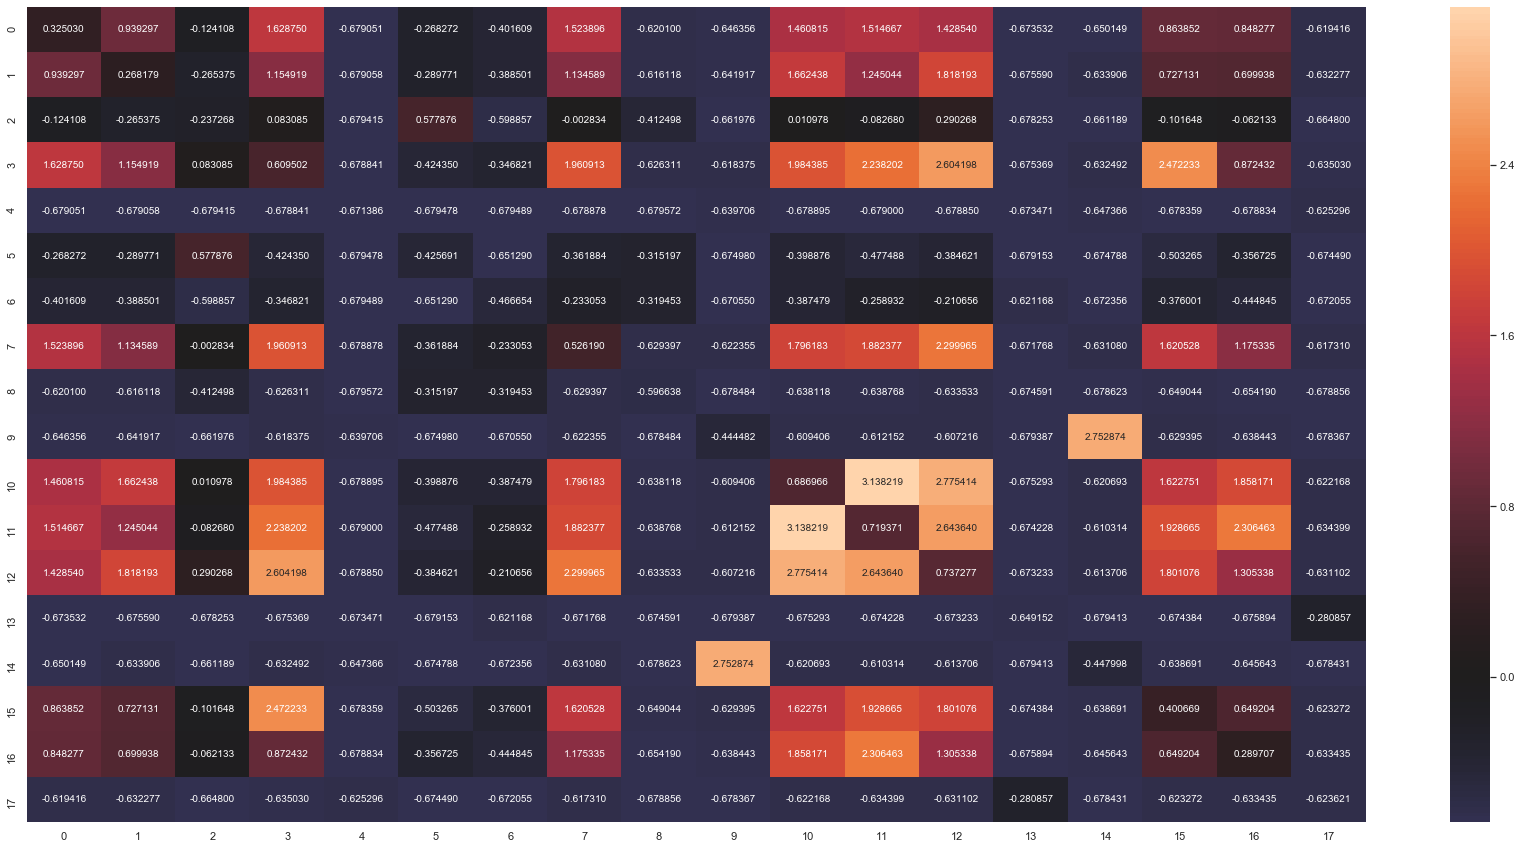

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
plt.rcParams['figure.figsize'] = [30, 15]
y_hat_heatmap = V_C.copy()
for i in range(y_s.shape[1]):
    y_hat_heatmap[i][i] = (np.sum(y_hat_heatmap[i])/(len(y_hat_heatmap[i]) - 1))
sns.heatmap((y_hat_heatmap-np.mean(y_hat_heatmap))/(np.std(y_hat_heatmap)), center=0, annot=True, fmt="f")

$ D_{C} = diag(d_{c}(1),..,d_{C}(m))$ <br>$d_{C}(i) = 
\sum_{j}^{m} V_{C}(i, j)$

In [17]:
D_C = []
for i in range(y_s.shape[1]):
    D_C.append(np.sum(V_C[i]))

In [18]:
for i in range(y_s.shape[1]):
    y_hat_i = torch.tensor(Y_hat.iloc[i,:].values).type(dtype)
    V_C[i][i] = Vc_distance(y_hat_i, y_hat_i)
V_C = torch.from_numpy(V_C).float()

In [19]:
D_C = torch.Tensor(D_C).float()
D_C = torch.diag(D_C)

$ L_{C}=I-D_{C}^{-\frac{1}{2}} V_{C} D_{C}^{-\frac{1}{2}} $

In [20]:
D_C_sqrt_inverse = torch.sqrt(torch.inverse(D_C))
L_C = torch.eye(18) - torch.mm(D_C_sqrt_inverse, torch.mm(V_C, D_C_sqrt_inverse))

In [21]:
L_C.shape, torch.mm(torch.mm(Z.permute((1,0)), L_C), Z).shape

(torch.Size([18, 18]), torch.Size([1484, 1484]))

$ \operatorname{tr}\left(Z^{T} L_{C} Z\right)=\sum_{k=1}^{n} \sum_{i, j}^{m} V_{C}(i, j)\left(\frac{Z_{i k}}{\sqrt{d_{C}(i)}}-\frac{Z_{j k}}{\sqrt{d_{C}(j)}}\right) $

In [22]:
trace_z_class_z = torch.trace(torch.mm(torch.mm(Z.permute((1,0)), L_C), Z))

Let's compute
$\operatorname{tr}\left(Z L_{X} Z^{T}\right)=\sum_{k=1}^{m} \sum_{i, j}^{n} V_{X}(i, j)\left(\frac{Z_{k i}}{\sqrt{d_{X}(i)}}-\frac{Z_{k j}}{\sqrt{d_{X}(j)}}\right)^{2} $

In [23]:
trace_z_samples_z = torch.trace(torch.mm(torch.mm(Z, L_X), Z.permute((1,0))))

In [24]:
trace_z_samples_z

tensor(26348.8984)

And we want to minimize Difference between (Z and Y)

$ \begin{aligned} Z_{X}^{*} &=\arg \min _{Z_{X}} \frac{1}{2}\left\|Z_{X}-Y\right\|_{\mathcal{F}}^{2}+\frac{\lambda_{X}}{2} \operatorname{tr}\left(Z_{X} L_{X} Z_{X}^{T}\right) \\ Z^{*} &=\arg \min _{Z} \frac{1}{2}\left\|Z-Z_{X}^{*}\right\|_{\mathcal{F}}^{2}+\frac{\lambda_{C}}{2} \operatorname{tr}\left(Z^{T} L_{C} Z\right) \end{aligned} $
<br>

Closed-form solution MLML_appro $ Z^{*}=\left(1-\alpha_{X}\right)\left(1-\alpha_{C}\right)\left(I-\alpha_{C} \overline{L}_{C}\right)^{-1} Y\left(I-\alpha_{X} \overline{L}_{X}\right)^{-1} $

In [29]:
# Tune: a_x, a_c, lambda_X, lambda_C
lambda_X, lambda_C = [1.0] * 2
a_x = lambda_X / (lambda_X + 1)
a_c = lambda_C / (lambda_C + 1)
# Where a_x & a_c obviously within (0, 1)
L_bar_X = torch.mm(D_X_sqrt_inverse, torch.mm(V_X, D_X_sqrt_inverse))
L_bar_C = torch.mm(D_C_sqrt_inverse, torch.mm(V_C, D_C_sqrt_inverse))
L_bar_X.requires_grad()
L_bar_C.requires_grad()

Y_tens = torch.tensor(Y.values).float()
class_solve = torch.mm(torch.inverse(torch.eye(D_C.shape[0]) - a_c * L_bar_C), Y_tens)
mlml_appro = torch.mm(class_solve, (torch.inverse(torch.eye(D_X.shape[0]) - a_x * L_bar_X)))

torch.Size([1484, 1484])


In [26]:
mlml_appro

tensor([[ 0.6172,  0.1515,  0.1482,  ...,  0.6470,  0.1797,  0.6031],
        [ 0.1389,  0.1425,  0.5570,  ..., -0.2540,  0.1617,  0.1263],
        [ 0.2165,  0.2183,  0.2149,  ...,  0.2219,  0.2193,  0.2135],
        ...,
        [ 0.6800,  0.6716,  0.6695,  ...,  0.2038,  0.7111,  0.6668],
        [ 0.5882,  0.5772,  0.1472,  ...,  0.6142,  0.6106,  0.5642],
        [ 0.0040,  0.0217,  0.0040,  ...,  0.0216,  0.0217, -0.0136]])

In [27]:
# SneakPeek
Y_original = torch.tensor(y_modified_data_df.iloc[:,9:].values.T).float()
minimization = (Y_original - mlml_appro)**2

In [28]:
# Next backprop, ROC-AUC, Cross Validation.

Ignoring approximate solution

Exact solution: $\frac{\partial \mathcal{J}(Z)}{\partial Z}=2(Z-Y)+\lambda_{X} Z L_{X}+\lambda_{C} L_{C} Z=0$
<br>
In other words, $Z= \frac{2Y}{2+\lambda_{X} L_{X} + \lambda_{C} L_{C}} $